# Affiliation Statistics
This script will calculate the affiliations insights into the accepted papers based on the data from `./data-proceedings/authors.csv`.

Author: Sven Mayer (info@sven-mayer.com)

LICENSE: GPL-3.0 license 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import geopandas
gdf = geopandas.read_file("./utils/ne_10m_admin_0_countries_lakes.shp")[['ADMIN', 'ADM0_A3', 'geometry']]#.to_crs('+proj=robin')
gdf = gdf.rename(columns = {"ADMIN":"Country", "ADM0_A3":"Alpha-3"})


colors = ["#FF523F","#FFAD33","#198D6D","#6599FF","#683b96","#f07adb"]

In [2]:
df = pd.read_csv("./data-proceedings/authors.csv")

dfAuthorPaperCount = df.groupby(["Url", "Name"]).Year.count().reset_index()
dfAuthorPaperCount = dfAuthorPaperCount.rename(columns={"Year":"AuthorPaperCount"})
dfAuthorPaperCount = dfAuthorPaperCount.sort_values(by="AuthorPaperCount", ascending=False)

if ("AuthorPaperCount" in df.columns):
    df = df.drop(columns=["AuthorPaperCount"])

df = pd.merge(df, dfAuthorPaperCount[["Url", "AuthorPaperCount"]], left_on='Url', right_on='Url', how='left')


dfCount = df.Doi.value_counts()
dfCount = dfCount.reset_index()
dfCount = dfCount.rename(columns={'count': 'AuthorsOnPaperCount'})

if ("AuthorsOnPaperCount" in df.columns):
    df = df.drop(columns=["AuthorsOnPaperCount"])

df = pd.merge(df, dfCount, left_on='Doi', right_on='Doi', how='left')

df["AuthorContribution"] = 1/df.AuthorsOnPaperCount

print(f"Total number of authors: {len(df)}")

Total number of authors: 3714


In [3]:
dfAffiliation = df.groupby(["Affiliation"]).Year.count().reset_index()
dfAffiliation = dfAffiliation.rename(columns={"Year":"AuthorCount"})

dfX = df.groupby(["Affiliation"]).AuthorContribution.sum().reset_index()
dfX = dfX.rename(columns={"AuthorContribution":"AuthorContributionSum"})
dfAffiliation = pd.merge(dfAffiliation, dfX, on='Affiliation', how='outer')

dfX = df.groupby(["Affiliation", "Doi"]).Year.count().reset_index()
dfX = dfX.rename(columns={"Year":"PaperCount"})
dfX["PaperCount"] = 1
dfX = dfX.groupby("Affiliation").PaperCount.sum().reset_index()
dfAffiliation = pd.merge(dfAffiliation, dfX, on='Affiliation', how='outer')

dfX = df.groupby(["Affiliation", "Url"]).Year.count().reset_index()
dfX = dfX.rename(columns={"Year":"UniqueAuthorCount"})
dfX["UniqueAuthorCount"] = 1
dfX = dfX.groupby("Affiliation").UniqueAuthorCount.sum().reset_index()
dfAffiliation = pd.merge(dfAffiliation, dfX, on='Affiliation', how='outer')

dfAffiliation = dfAffiliation.sort_values(by="AuthorContributionSum", ascending=False)
dfAffiliation.head(10)

,Affiliation,AuthorCount,AuthorContributionSum,PaperCount,UniqueAuthorCount
222,Nokia,119,34.582143,55,80
170,LMU Munich,122,30.396429,50,69
384,University of Glasgow,83,25.366667,32,41
194,Microsoft,92,23.216667,33,67
305,Tampere University,67,16.550000,22,39
397,University of Lancaster,62,15.801587,26,37
213,National Taiwan University,84,13.332143,17,60
0,Aalborg University,46,13.292857,17,28
39,Carnegie Mellon University,58,13.120238,26,42
97,Georgia Institute of Technology,45,11.841667,15,34


In [4]:
print(f"A total of {len(dfAffiliation)} unique affiliations contributed to the conference.")

x = dfAffiliation[dfAffiliation.PaperCount == 1]
print(f"Notably, ({len(x)}) affiliations ({len(x)/len(dfAffiliation)*100:.2f}%) contributed to only one paper.")

print(f"On average, each affiliation contributed to {dfAffiliation.PaperCount.mean():.2f} papers (SD={dfAffiliation.PaperCount.std():.2f}).")

x = dfAffiliation[dfAffiliation.PaperCount > 5]
print(f"Only {len(x)} affiliations contributed to more than 5 papers ({len(x)/len(dfAffiliation)*100:.2f}%).")


x = dfAffiliation[dfAffiliation.PaperCount > 10]
print(f"Only {len(x)} affiliations contributed to more than 10 papers ({len(x)/len(dfAffiliation)*100:.2f}%).")

dfMoreThan15Papers = dfAffiliation[dfAffiliation.PaperCount > 15].sort_values("PaperCount", ascending=False)
print(f"Only {len(dfMoreThan15Papers)} affiliations contributed to more than 15 papers ({len(dfMoreThan15Papers)/len(dfAffiliation)*100:.2f}%).")
for i, e in dfMoreThan15Papers.iterrows():
    print(f"{e.Affiliation}: {e.PaperCount}")

A total of 496 unique affiliations contributed to the conference.
Notably, (265) affiliations (53.43%) contributed to only one paper.
On average, each affiliation contributed to 3.29 papers (SD=5.21).
Only 74 affiliations contributed to more than 5 papers (14.92%).
Only 32 affiliations contributed to more than 10 papers (6.45%).
Only 14 affiliations contributed to more than 15 papers (2.82%).
Nokia: 55
LMU Munich: 50
Microsoft: 33
University of Glasgow: 32
University of Lancaster: 26
Carnegie Mellon University: 26
Tampere University: 22
University of Stuttgart: 19
Telefonica: 18
University of Washington: 18
National Taiwan University: 17
Aalborg University: 17
University of Bremen: 17
University of Oldenburg: 16


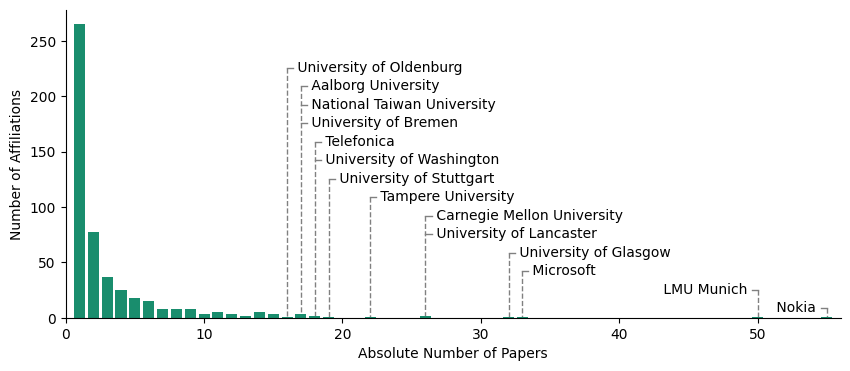

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(dfAffiliation.PaperCount, range=(0, dfAffiliation.PaperCount.max()+1), bins=dfAffiliation.PaperCount.max()+1, align='left', rwidth=0.8, color=colors[2])

ax.set_ylabel("Number of Affiliations")
ax.set_xlabel("Absolute Number of Papers")
ax.set_xlim(0, dfAffiliation.PaperCount.max()+1)

dfMoreThan15Papers = dfAffiliation[dfAffiliation.PaperCount > 15]

paddingBottom = 20
paddingTop  = 8
space = dfAffiliation.groupby("PaperCount").Affiliation.count().max() - dfMoreThan15Papers.groupby("PaperCount").Affiliation.count().max() - paddingBottom - paddingTop
spacing = space/len(dfMoreThan15Papers)
nameSpacer = dfAffiliation.PaperCount.max() * 0.008


lastPaperCount = 0
for i, e in dfMoreThan15Papers.sort_values(["PaperCount", "Affiliation"]).reset_index().iterrows():
    ha = "left"
    if e.PaperCount > 40:
        ha = "right"

    if ha == "left":
        plt.text(e.PaperCount+nameSpacer,space - (i * spacing) - paddingTop, f" {e.Affiliation} ", ha=ha, va='center')
    else:
        plt.text(e.PaperCount-nameSpacer,space - (i * spacing) - paddingTop, f" {e.Affiliation} ", ha=ha, va='center')

    if (lastPaperCount != e.PaperCount):
        plt.plot([e.PaperCount, e.PaperCount], [space - (i * spacing) - paddingTop,0], color='grey', linewidth=1, ls='--', zorder=-99)

    if ha == "left":
        plt.plot([e.PaperCount, e.PaperCount + nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)
    else:
        plt.plot([e.PaperCount, e.PaperCount - nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)

    lastPaperCount = e.PaperCount

ax.spines[['right', 'top']].set_visible(False)
plt.savefig("./figures/affiliation_paperCount.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)

In [6]:
dfAffiliation

,Affiliation,AuthorCount,AuthorContributionSum,PaperCount,UniqueAuthorCount
222,Nokia,119,34.582143,55,80
170,LMU Munich,122,30.396429,50,69
384,University of Glasgow,83,25.366667,32,41
194,Microsoft,92,23.216667,33,67
305,Tampere University,67,16.550000,22,39
...,...,...,...,...,...
418,University of Neuchâtel,1,0.111111,1,1
231,Old Dominion University,1,0.111111,1,1
362,University of Bonn,1,0.111111,1,1
321,Texas A&M University,1,0.100000,1,1


In [7]:
dfTopContributer = dfAffiliation[dfAffiliation.PaperCount > 15]

print(f"A total of {len(dfTopContributer)} affiliations have contributed to more than 15 papers each.")
uniqueContributions = len(df[df.Affiliation.isin(dfTopContributer.Affiliation)].groupby("Doi").count())

print(f"Collectively, they contributed to {uniqueContributions} papers")

countAllPapers = df.Doi.nunique()
print(f"Notably, these {len(dfTopContributer)} leading affiliations account for {uniqueContributions/countAllPapers*100:.2f}% of all papers published at MobileHCI, underscoring their significant influence on the conference’s research output.")

A total of 14 affiliations have contributed to more than 15 papers each.
Collectively, they contributed to 332 papers
Notably, these 14 leading affiliations account for 34.66% of all papers published at MobileHCI, underscoring their significant influence on the conference’s research output.


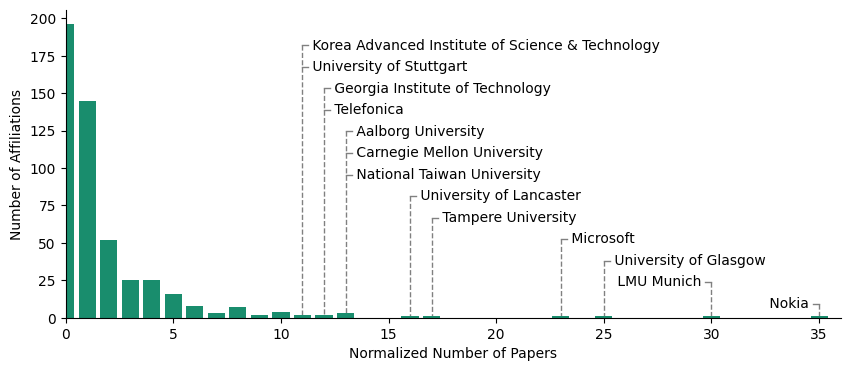

In [8]:
dfAffiliation.AuthorContributionSum = dfAffiliation.AuthorContributionSum.round()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(dfAffiliation.AuthorContributionSum, range=(0, dfAffiliation.AuthorContributionSum.max()+1), bins=int(np.ceil(dfAffiliation.AuthorContributionSum.max()))+1, align='left', rwidth=0.8, color=colors[2])

ax.set_ylabel("Number of Affiliations")
ax.set_xlabel("Normalized Number of Papers")
ax.set_xlim(0, dfAffiliation.AuthorContributionSum.max()+1)

dfMoreThan15Papers = dfAffiliation[dfAffiliation.AuthorContributionSum > 10]

paddingBottom = 1
paddingTop  = 5
space = dfAffiliation.groupby("AuthorContributionSum").Affiliation.count().max() - dfMoreThan15Papers.groupby("AuthorContributionSum").Affiliation.count().max() - paddingBottom - paddingTop
spacing = space/len(dfMoreThan15Papers)
nameSpacer = dfAffiliation.AuthorContributionSum.max() * 0.008


lastAuthorContributionSum = 0
for i, e in dfMoreThan15Papers.sort_values(["AuthorContributionSum", "Affiliation"]).reset_index().iterrows():
    ha = "left"
    if e.AuthorContributionSum > 25:
        ha = "right"

    if ha == "left":
        plt.text(e.AuthorContributionSum+nameSpacer,space - (i * spacing) - paddingTop, f" {e.Affiliation} ", ha=ha, va='center')
    else:
        plt.text(e.AuthorContributionSum-nameSpacer,space - (i * spacing) - paddingTop, f" {e.Affiliation} ", ha=ha, va='center')

    if (lastAuthorContributionSum != e.AuthorContributionSum):
        plt.plot([e.AuthorContributionSum, e.AuthorContributionSum], [space - (i * spacing) - paddingTop,0], color='grey', linewidth=1, ls='--', zorder=-99)

    if ha == "left":
        plt.plot([e.AuthorContributionSum, e.AuthorContributionSum + nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)
    else:
        plt.plot([e.AuthorContributionSum, e.AuthorContributionSum - nameSpacer], [space - (i * spacing) - paddingTop, space - (i * spacing) - paddingTop], color='grey', linewidth=1)

    lastAuthorContributionSum = e.AuthorContributionSum

ax.spines[['right', 'top']].set_visible(False)
plt.savefig("./figures/affiliation_AuthorContributionSum.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)

In [9]:
dfExport = dfAffiliation[['Affiliation', 'AuthorCount', 'UniqueAuthorCount', 'AuthorContributionSum', 'PaperCount']]
dfExport = dfExport.sort_values(by="PaperCount", ascending=False)
dfExport.to_csv("./export/affiliations.csv", index=False)

# Network

In [10]:
#! pip3 install --upgrade graphviz networkx
import networkx as nx
import itertools
from tqdm import tqdm


In [11]:
dfAffiliation["Color"] = "blue"

color20 = ["#ec87ff","#5c9500","#58505c","#7ee0ff","#f91823","#977c00","#c0687c","#1d7e71","#ff703e","#4c6220","#bfb3ff","#e4d600","#872198","#c6ff16","#e82cd3","#38ff6d","#99273d","#92a3ab","#3257bf","#e7b445",]

i = 0
for index, e in dfAffiliation[dfAffiliation["PaperCount"] > 15].iterrows():
    dfAffiliation.loc[index, "Color"] = color20[i]
    i += 1 

In [12]:
connections = []
for doi in df.Doi.unique():
    dfX = df[(df.Doi == doi) & (df.Affiliation.notnull())]
    lst = dfX.Affiliation.unique()
    for i in range(0, len(lst)):
        for j in range(i+1, len(lst)):
            connections.append(sorted([lst[i], lst[j]]))

In [13]:
dfNetwork = pd.DataFrame(connections, columns=["source", "target"])
dfNetwork["weight"] = 1
dfNetwork = dfNetwork.groupby(["source", "target"]).weight.sum()
#.reset_index()
dfNetwork = dfNetwork.reset_index()
dfNetwork = dfNetwork.sort_values(by="weight", ascending=False)
dfNetwork["color"] = "grey"

dfNetwork["my_edge_key"] = dfNetwork.apply(lambda x: f"{x.source}-{x.target}", axis=1)

dfNetwork = pd.merge(dfNetwork, dfAffiliation[["Affiliation", "PaperCount"]], left_on='source', right_on='Affiliation', how='left')
del dfNetwork["Affiliation"]

dfNetwork

,source,target,weight,color,my_edge_key,PaperCount
0,OFFIS - Institute for IT,University of Oldenburg,12,grey,OFFIS - Institute for IT-University of Oldenburg,12
1,Nokia,Tampere University,6,grey,Nokia-Tampere University,55
2,LMU Munich,Utrecht University,6,grey,LMU Munich-Utrecht University,50
3,Bundeswehr University Munich,LMU Munich,5,grey,Bundeswehr University Munich-LMU Munich,7
4,DoCoMo Communications Laboratories Europe GmbH,LMU Munich,4,grey,DoCoMo Communications Laboratories Europe GmbH...,9
...,...,...,...,...,...,...
788,"Good Research, Berkeley",University of Nottingham,1,grey,"Good Research, Berkeley-University of Nottingham",1
789,Google,IBM,1,grey,Google-IBM,14
790,Google,Korea Advanced Institute of Science & Technology,1,grey,Google-Korea Advanced Institute of Science & T...,14
791,Google,Pompeu Fabra University,1,grey,Google-Pompeu Fabra University,14


## All affilations that collaborated on at least one paper

434it [00:01, 300.62it/s]
793it [00:02, 281.87it/s]


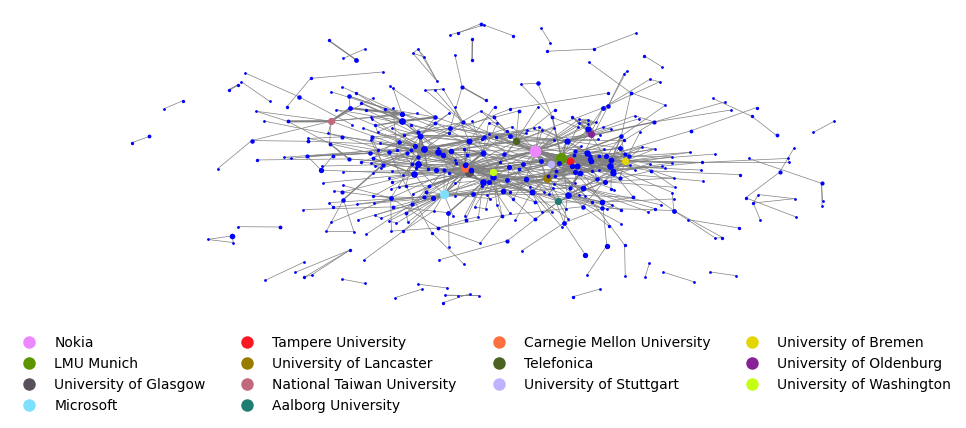

In [ ]:
G = nx.from_pandas_edgelist(dfNetwork, 'source', 'target', edge_attr=True, create_using=nx.MultiGraph())

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
layout = nx.spring_layout(G, k=0.15, seed=4572321)

for i, node in tqdm(enumerate(G.nodes(data=True))):
    nx.draw_networkx_nodes(G,
                           pos=layout,
                           nodelist=[node[0]],
                           node_size=dfAffiliation[dfAffiliation["Affiliation"] == node[0]]["PaperCount"].iloc[0], 
                           node_color=dfAffiliation[dfAffiliation["Affiliation"] == node[0]]["Color"].iloc[0],
                           ax=ax)

for i, edge in tqdm(enumerate(G.edges(data=True))):
    nx.draw_networkx_edges(G, pos=layout, edgelist=[(edge[0], edge[1])], width=edge[2]["weight"]*.5, edge_color=edge[2]["color"], ax=ax)

patches = []
for i, e in dfAffiliation[dfAffiliation["PaperCount"] > 15].iterrows():
    patches.append(plt.Line2D([0], [0], marker='o', color='w', label=e["Affiliation"], markerfacecolor=e["Color"], markersize=10))

ax.legend(handles=patches, loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.5, -0.35))
ax.axis('off')

plt.show()

## All affilations that collaborate on more than one paper

91it [00:00, 337.15it/s]
90it [00:00, 615.59it/s]


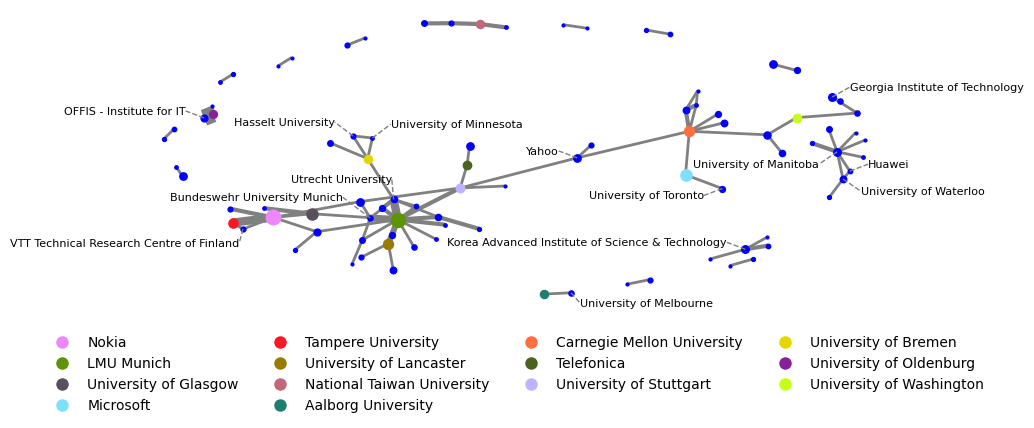

In [310]:
G = nx.from_pandas_edgelist(dfNetwork[dfNetwork.weight > 1], 'source', 'target', edge_attr=True, create_using=nx.MultiGraph())


fig, ax = plt.subplots(1, 1, figsize=(10, 4))

layout = nx.spring_layout(G, dim=2, k=0.1, seed=4572321, weight=None,  scale=1, iterations=20, pos={"Nokia":[0,0]}, fixed=["Nokia"], threshold=0.000001)
for l in layout.keys():
    layout[l] = layout[l] / 3
layout = nx.spring_layout(G, dim=2, k=0.3, seed=42, weight="weight",  scale=.2, iterations=50, pos=layout, threshold=0.00000001)

layout["Microsoft"] = layout["Microsoft"]-np.array([0.04,0.04])
layout["University of Toronto"] = layout["Microsoft"]+np.array([0.02,-0.02])
layout["University of Washington"] = layout["University of Washington"]+np.array([-0.02,0.02])
layout["Fraunhofer Institute for Applied Information Technology"] = layout["University of Lancaster"]+np.array([-0.015,-0.02])

for i, node in tqdm(enumerate(G.nodes(data=True))):
    nx.draw_networkx_nodes(G,
                           pos=layout,
                           nodelist=[node[0]],
                           node_size=dfAffiliation[dfAffiliation["Affiliation"] == node[0]]["PaperCount"].iloc[0]*2, 
                           node_color=dfAffiliation[dfAffiliation["Affiliation"] == node[0]]["Color"].iloc[0],
                           ax=ax)

for i, edge in tqdm(enumerate(G.edges(data=True))):
    nx.draw_networkx_edges(G, pos=layout, edgelist=[(edge[0], edge[1])], width=edge[2]["weight"], edge_color=edge[2]["color"], ax=ax)

highlight = {"OFFIS - Institute for IT":[-.01, +.01, 'right'],
             "Yahoo":[-.01, +.01, 'right'], 
             "Korea Advanced Institute of Science & Technology":[-.01, +.01, 'right'],
             "Bundeswehr University Munich":[-.015, +.03, 'right'],
             "University of Melbourne":[0.005, -.015, 'left'],
             "University of Toronto":[-.01, -.01, 'right'],
             "Georgia Institute of Technology":[0.01, 0.015, 'left'], 
             "University of Manitoba":[-0.01, -0.018, 'right'],
             "University of Waterloo":[0.01, -0.018, 'left'],
             "Huawei":[0.01, 0.01, 'left'],
             "VTT Technical Research Centre of Finland":[-0.002, -0.02, 'right'],
             "Utrecht University" :[-0.001, 0.03, 'right'],
             "University of Minnesota":[0.01, 0.02, 'left'],
             "Hasselt University":[-0.01, 0.02, 'right'],}

for label, info in highlight.items():
    xy1 = layout[label]
    xy2 = [xy1[0]+info[0], xy1[1]+info[1]]
    plt.text(xy2[0], xy2[1], label, fontsize=8, ha=info[2], va='center', color='black')
    ax.plot([xy1[0], xy2[0]], [xy1[1], xy2[1]], color='gray', linewidth=1, ls='--')

patches = []
for i, e in dfAffiliation[dfAffiliation["PaperCount"] > 15].iterrows():
    patches.append(plt.Line2D([0], [0], marker='o', color='w', label=e["Affiliation"], markerfacecolor=e["Color"], markersize=10))

ax.legend(handles=patches, loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.5, -0.35))
ax.axis('off')


plt.savefig("./figures/affiliation_network.jpg", bbox_inches='tight', pad_inches=0, dpi=300, transparent=False)
plt.show()